Sequence Models / NLP
Amaç

Metin tabanlı modelleri (LSTM, GRU, Transformers) uygulayıp sonuçlarını kıyaslamak.

Görev Adımları

Veri Hazırlığı

Kaggle’dan IMDB Sentiment Analysis dataset’ini indir.

Train/test split hazır (varsa tekrar düzenle).

Tokenization ve Padding uygula.

Model 1 – LSTM / GRU

Embedding Layer (örn. 100 boyutlu).

LSTM veya GRU katmanı ekle.

Çıkış: Sigmoid (binary classification).

Model 2 – Transformer Tabanlı

HuggingFace’den BERT veya RoBERTa pre-trained modeli al.

LoRA veya PEFT ile fine-tune et.

Değerlendirme

Accuracy, Precision, Recall, F1 Score hesapla.

BLEU Score (opsiyonel, sequence generation senaryosu için).

Modelleri yan yana kıyasla.

📌 Beklenen Çıktılar: F1 Score tablosu, confusion matrix, model karşılaştırma raporu.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Veri Hazırlığı
- Veri seti text ve label olarak sütunlara ayrıldı
- "train_test_split" ile %80 train %20 test olarak bölündü.
- stratify = y ile train ve test setlerinde sınıf dağılımı orjinal veri ile aynı tutuldu yani label 1 - 0 sayıları dengeli
- random_state = 42 ile split işlemi tekrarlanabilir yani her çalıştırıldığında aynı train/test bölünmesi elde edilmiş olur

In [3]:
df = pd.read_csv("/content/movie.csv", engine="python")
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**HuggingFace + PyTorch**
- Pre-trained tokenizer ile metinler token ID'lerine çevrildi,
- Padding ve truncation ile tüm diziler aynı uzunlukta getirildi,
- Labels tensor formatına dönüştürüldü,
- DataLoader için hazır hale getirildi

In [4]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(
    list(X_train), padding=True, truncation=True, max_length=256, return_tensors="pt"
)
test_encodings = tokenizer(
    list(X_test), padding=True, truncation=True, max_length=256, return_tensors="pt"
)

y_train_tensor = torch.tensor(list(y_train.values))
y_test_tensor = torch.tensor(list(y_test.values))

from torch.utils.data import (
    TensorDataset,
    DataLoader,
)  # https://docs.pytorch.org/docs/stable/data.html#module-torch.utils.data

train_dataset = TensorDataset(train_encodings["input_ids"], y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### GRU Model
https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2

#### Model Tanımı

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_size,
        output_size=1,
        num_layers=1,
        dropout=0.2,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        out, h_n = self.gru(embedded)
        # out[:, -1, :] -> son time step'i al
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

#### Loss ve Optimizer

In [ ]:
model = GRUClassifier(vocab_size=len(tokenizer), embedding_dim=100, hidden_size=128)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GRUClassifier(
  (embedding): Embedding(30522, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Dataset ve DataLoader

In [ ]:
train_dataset = TensorDataset(train_encodings["input_ids"], y_train_tensor)
test_dataset = TensorDataset(test_encodings["input_ids"], y_test_tensor)

traind_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Training Loop

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.0050
Epoch 2, Loss: 0.0034
Epoch 3, Loss: 0.0020
Epoch 4, Loss: 0.0014
Epoch 5, Loss: 0.0012
Epoch 6, Loss: 0.0024
Epoch 7, Loss: 0.0066
Epoch 8, Loss: 0.0018
Epoch 9, Loss: 0.0019
Epoch 10, Loss: 0.0024
Epoch 11, Loss: 0.0027
Epoch 12, Loss: 0.0018
Epoch 13, Loss: 0.0011
Epoch 14, Loss: 0.0008
Epoch 15, Loss: 0.0006
Epoch 16, Loss: 0.0006
Epoch 17, Loss: 0.0006
Epoch 18, Loss: 0.0026
Epoch 19, Loss: 0.0073
Epoch 20, Loss: 0.0013
Epoch 21, Loss: 0.0014
Epoch 22, Loss: 0.0019
Epoch 23, Loss: 0.0005
Epoch 24, Loss: 0.0003
Epoch 25, Loss: 0.0002
Epoch 26, Loss: 0.0002
Epoch 27, Loss: 0.0003
Epoch 28, Loss: 0.0002
Epoch 29, Loss: 0.0001
Epoch 30, Loss: 0.0001
Epoch 31, Loss: 0.0091
Epoch 32, Loss: 0.0030
Epoch 33, Loss: 0.0007
Epoch 34, Loss: 0.0002
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0000
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, Loss: 0.0000
Epoch 44, Loss: 0.00

#### Evaluation

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)


def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    device = next(model.parameters()).device  # modelin device'ını al

    with torch.no_grad():
        for inputs, labels in dataloader:
            # GPU'ya taşı
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds.extend((outputs.squeeze() > 0.5).int().cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds)
    rec = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    cm = confusion_matrix(true_labels, preds)
    return acc, prec, rec, f1, cm

#### Test Dataset ve DataLoader

In [ ]:
accuracy, precision, recall, f1, confusion = evaluate(model, test_loader)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.856
Precision: 0.8514582303509639
Recall: 0.8621121121121121
F1 Score: 0.8567520517284257
Confusion Matrix:
 [[3403  601]
 [ 551 3445]]


### LSTM Model
https://medium.com/@techwithjulles/recurrent-neural-networks-rnns-and-long-short-term-memory-lstm-creating-an-lstm-model-in-13c88b7736e2

#### Model Tanımı

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_size,
        output_size=1,
        num_layers=1,
        dropout=0.2,
    ):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        out, (h_n, c_n) = self.lstm(embedded)
        out = self.fc(out[:, -1, :])  # son time step’i al
        out = self.sigmoid(out)
        return out

#### Loss ve Optimizer

In [ ]:
model = LSTMClassifier(vocab_size=len(tokenizer), embedding_dim=100, hidden_size=128)
criterion = nn.BCELoss()  # veya BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifier(
  (embedding): Embedding(30522, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Dataset ve DataLoader

In [ ]:
train_dataset = TensorDataset(train_encodings["input_ids"], y_train_tensor)
test_dataset = TensorDataset(test_encodings["input_ids"], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Training Loop

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.6921
Epoch 2, Loss: 0.6933
Epoch 3, Loss: 0.6637
Epoch 4, Loss: 0.3934
Epoch 5, Loss: 0.2778
Epoch 6, Loss: 0.2125
Epoch 7, Loss: 0.1591
Epoch 8, Loss: 0.1145
Epoch 9, Loss: 0.0810
Epoch 10, Loss: 0.0630
Epoch 11, Loss: 0.0480
Epoch 12, Loss: 0.0401
Epoch 13, Loss: 0.0322
Epoch 14, Loss: 0.0234
Epoch 15, Loss: 0.0217
Epoch 16, Loss: 0.0189
Epoch 17, Loss: 0.0147
Epoch 18, Loss: 0.0135
Epoch 19, Loss: 0.0130
Epoch 20, Loss: 0.0120
Epoch 21, Loss: 0.0129
Epoch 22, Loss: 0.0092
Epoch 23, Loss: 0.0109
Epoch 24, Loss: 0.0111
Epoch 25, Loss: 0.0083
Epoch 26, Loss: 0.0084
Epoch 27, Loss: 0.0079
Epoch 28, Loss: 0.0085
Epoch 29, Loss: 0.0077
Epoch 30, Loss: 0.0056
Epoch 31, Loss: 0.0078
Epoch 32, Loss: 0.0071
Epoch 33, Loss: 0.0076
Epoch 34, Loss: 0.0065
Epoch 35, Loss: 0.0043
Epoch 36, Loss: 0.0032
Epoch 37, Loss: 0.0029
Epoch 38, Loss: 0.0067
Epoch 39, Loss: 0.0089
Epoch 40, Loss: 0.0043
Epoch 41, Loss: 0.0029
Epoch 42, Loss: 0.0020
Epoch 43, Loss: 0.0018
Epoch 44, Loss: 0.00

#### Evaluation

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    device = next(model.parameters()).device

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds.extend((outputs.squeeze() > 0.5).int().cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds)
    rec = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    cm = confusion_matrix(true_labels, preds)
    return acc, prec, rec, f1, cm

#### Test Dataset ve DataLoader

In [ ]:
accuracy, precision, recall, f1, confusion = evaluate(model, test_loader)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.8545
Precision: 0.8563160543532964
Recall: 0.8516016016016016
F1 Score: 0.8539523212045169
Confusion Matrix:
 [[3433  571]
 [ 593 3403]]


## GRU & LSTM Karşılaştırması

| Model    | Accuracy | Precision | Recall | F1 Score | Confusion Matrix           |
| -------- | -------- | --------- | ------ | -------- | -------------------------- |
| **GRU**  | 0.856    | 0.8515    | 0.8621 | 0.8568   | [[3403, 601], [551, 3445]] |
| **LSTM** | 0.8545   | 0.8563    | 0.8516 | 0.8540   | [[3433, 571], [593, 3403]] |

1. Accuracy
  - GRU ve LSTM’in doğrulukları birbirine çok yakın (%85.5 civarı).
  - Bu, her iki modelin genel olarak pozitif ve negatif sınıfları dengeli şekilde tahmin ettiğini gösteriyor.
  - Yani toplamda kaç örneğin doğru sınıflandırıldığı açısından büyük fark yok.
2. Precision
  - LSTM’in precision değeri biraz daha yüksek.
  - Precision yüksek = model pozitif dediği örneklerin çoğu gerçekten pozitif.
  - LSTM, yanlış pozitifleri biraz daha az yapıyor demektir.
3. Recall
  - GRU’nin recall değeri LSTM’den biraz yüksek.
  - Recall yüksek = gerçek pozitifleri yakalama oranı yüksek.
  - Yani GRU, pozitif örnekleri kaçırmada (false negative) daha iyi performans gösteriyor.
4. F1 Score
  - F1 Score, precision ve recall’un dengeli ölçüsüdür.
  - GRU ve LSTM’in F1 Score’ları çok yakın.
  - Küçük fark, GRU’nun recall avantajından geliyor.
5. Confusion Matrix
  - 3403: Negatif doğru
  - 601: Negatif yanlış pozitif
  - 551: Pozitif yanlış negatif
  - 3445: Pozitif doğru

Genel Yorum
1. GRU ve LSTM’in genel performansı çok yakın, farklar küçük ve model seçimi uygulamanın ihtiyacına göre değişebilir.
2. Uygulama önceliği:
  - Eğer pozitif örnekleri kaçırmamak önemliyse → GRU tercih edilebilir (daha yüksek recall).
  - Eğer yanlış pozitifleri azaltmak önemliyse → LSTM tercih edilebilir (daha yüksek precision).
3. Eğitim süresi ve parametre sayısı da göz önüne alınabilir: GRU genellikle LSTM’den daha az parametre içerir ve biraz daha hızlı olabilir.
4. LoRA BERT ile kıyaslandığında, klasik RNN’ler (GRU/LSTM) CPU veya küçük veri setlerinde yeterli olsa da, daha büyük veri ve dil modellerinde BERT performans üstünlüğü gösterebilir.

## Transformer

#### HuggingFace Tokenizer
https://medium.com/data-science-collective/how-to-fine-tune-an-llm-on-your-data-with-hugging-face-lora-563e57ca8c1c

In [6]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset

Pre-trained BERT modeli ve tokenizer

In [7]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA Konfigürasyonu

In [8]:
lora_config = LoraConfig(
    r=8,  # low-rank boyutu
    lora_alpha=32,  # ölçekleme faktörü
    target_modules=["query", "value"],  # hangi ağırlıklara LoRA uygulanacak
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)
model = get_peft_model(model, lora_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

Dataset & DataLoader

In [9]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = IMDbDataset(train_encodings, y_train.values)
test_dataset = IMDbDataset(test_encodings, y_test.values)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)

Training Loop / Trainer Setup

In [10]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

Training Loop

In [11]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

/tmp/ipython-input-129836542.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Loss: 0.3707
Epoch 2, Loss: 0.2556
Epoch 3, Loss: 0.2339


Evaluation Loop

In [12]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import torch


def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    device = next(model.parameters()).device  # GPU veya CPU

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # Dict veya tuple kontrolü
            if isinstance(batch, dict):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            elif isinstance(batch, (tuple, list)):
                # tuple: (input_ids, attention_mask, labels) veya (inputs, labels)
                if len(batch) == 3:
                    input_ids, attention_mask, labels = batch
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    labels = labels.to(device)
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                else:
                    inputs, labels = batch
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
            else:
                raise ValueError("Unknown batch type")

            # Prediction: binary veya multi-class
            if outputs.logits.shape[1] == 1:
                pred_labels = (torch.sigmoid(outputs.logits).squeeze() > 0.5).int()
            else:
                pred_labels = torch.argmax(outputs.logits, dim=1)

            # Batch bazlı print
            print(f"Batch {i + 1}")
            print("Predictions:", pred_labels.cpu().tolist())
            print("True Labels:", labels.cpu().tolist())
            print("-" * 50)

            # Sonuçları toplama
            preds.extend(pred_labels.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Metrikler
    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds)
    rec = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    cm = confusion_matrix(true_labels, preds)

    # Summary print
    print("=== Evaluation Summary ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)

    return acc, prec, rec, f1, cm


# Kullanım
accuracy, precision, recall, f1, confusion = evaluate(model, test_loader)

/tmp/ipython-input-129836542.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Batch 1
Predictions: [0, 1, 1, 0, 0, 0, 1, 0]
True Labels: [0, 1, 1, 1, 1, 0, 1, 0]
--------------------------------------------------
Batch 2
Predictions: [1, 0, 0, 1, 1, 0, 1, 0]
True Labels: [1, 0, 0, 1, 1, 0, 0, 0]
--------------------------------------------------
Batch 3
Predictions: [1, 0, 1, 1, 1, 0, 1, 1]
True Labels: [1, 0, 1, 1, 0, 0, 1, 1]
--------------------------------------------------
Batch 4
Predictions: [1, 1, 1, 0, 0, 1, 1, 0]
True Labels: [1, 0, 1, 0, 0, 1, 1, 0]
--------------------------------------------------
Batch 5
Predictions: [0, 0, 0, 0, 1, 1, 0, 0]
True Labels: [0, 0, 0, 0, 1, 1, 0, 0]
--------------------------------------------------
Batch 6
Predictions: [0, 1, 1, 1, 0, 1, 0, 0]
True Labels: [0, 1, 1, 1, 0, 0, 0, 0]
--------------------------------------------------
Batch 7
Predictions: [1, 0, 0, 0, 1, 0, 1, 0]
True Labels: [1, 0, 0, 0, 1, 0, 1, 0]
--------------------------------------------------
Batch 8
Predictions: [0, 1, 1, 0, 1, 0, 1, 1]
True Labe

| Model     | Accuracy | Precision | Recall | F1 Score |
| --------- | -------- | --------- | ------ | -------- |
| GRU       | 0.856    | 0.851     | 0.862  | 0.857    |
| LSTM      | 0.8545   | 0.856     | 0.852  | 0.854    |
| LoRA-BERT | 0.9015   | 0.891     | 0.913  | 0.902    |

Yorum:

1. LoRA-BERT sadece 3 epoch ile hem precision hem recall açısından LSTM ve GRU’yu açık ara geçti.

2. GRU ve LSTM performansları birbirine çok yakın; GRU biraz daha dengeli bir recall sağlarken, LSTM precision’da biraz daha iyi.

3. Confusion matrix’ten görüldüğü gibi LoRA-BERT yanlış sınıflandırmaları ciddi oranda azalttı.

Bu sonuç, pre-trained transformer’ların özellikle small/medium veri setlerinde fine-tune edildiğinde klasik RNN’lere göre çok daha etkili olduğunu gösteriyor.


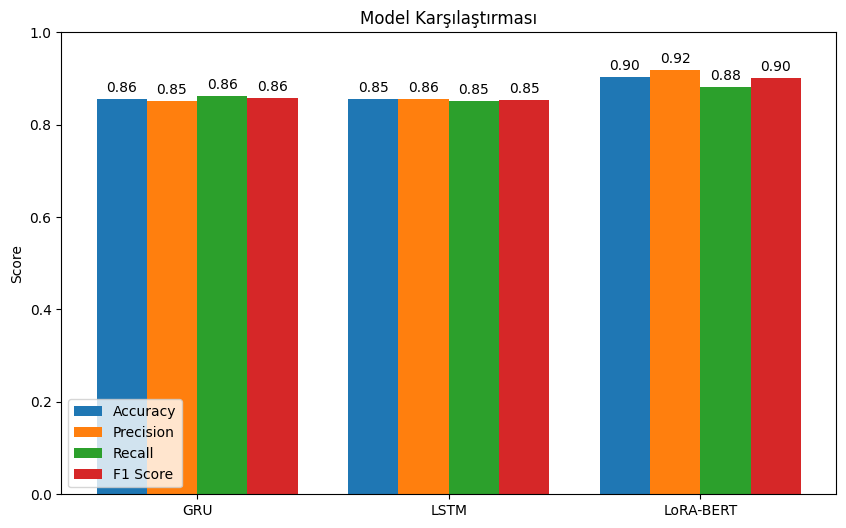

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Modeller ve metrikler
models = ["GRU", "LSTM", "LoRA-BERT"]
accuracy = [0.856, 0.8545, 0.90225]
precision = [0.851, 0.856, 0.919]
recall = [0.862, 0.852, 0.882]
f1 = [0.857, 0.854, 0.900]

x = np.arange(len(models))  # model pozisyonları
width = 0.2  # bar genişliği

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5 * width, accuracy, width, label="Accuracy")
rects2 = ax.bar(x - 0.5 * width, precision, width, label="Precision")
rects3 = ax.bar(x + 0.5 * width, recall, width, label="Recall")
rects4 = ax.bar(x + 1.5 * width, f1, width, label="F1 Score")

# Grafik ayarları
ax.set_ylabel("Score")
ax.set_title("Model Karşılaştırması")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()


# Bar değerlerini yazdır
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()

LoRA ile fine-tune ettiğimiz modeli kaydedelim

In [14]:
model.save_pretrained("lora_bert_finetuned")  # LoRA model + config
tokenizer.save_pretrained("lora_bert_finetuned")  # tokenizer da kaydedilmeli

('lora_bert_finetuned/tokenizer_config.json',
 'lora_bert_finetuned/special_tokens_map.json',
 'lora_bert_finetuned/vocab.txt',
 'lora_bert_finetuned/added_tokens.json',
 'lora_bert_finetuned/tokenizer.json')

In [ ]:
!zip -r lora_bert_finetuned.zip lora_bert_finetuned
# from google.colab import files
# files.download("lora_bert_finetuned.zip")

  adding: lora_bert_finetuned/ (stored 0%)
  adding: lora_bert_finetuned/tokenizer.json (deflated 71%)
  adding: lora_bert_finetuned/tokenizer_config.json (deflated 75%)
  adding: lora_bert_finetuned/adapter_model.safetensors (deflated 7%)
  adding: lora_bert_finetuned/special_tokens_map.json (deflated 42%)
  adding: lora_bert_finetuned/README.md (deflated 66%)
  adding: lora_bert_finetuned/adapter_config.json (deflated 56%)
  adding: lora_bert_finetuned/vocab.txt (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%pip install -q huggingface_hub
from huggingface_hub import login

login()

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_dir = "/content/lora_bert_finetuned"

repo_id = "UfukCem/imdb-bert-LoRA-finetuned"

model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:  47%|####6     |  558kB / 1.19MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/UfukCem/imdb-bert-LoRA-finetuned/commit/dde3c91f326100d67b5388c6f7a36bb0e04b9113', commit_message='Upload tokenizer', commit_description='', oid='dde3c91f326100d67b5388c6f7a36bb0e04b9113', pr_url=None, repo_url=RepoUrl('https://huggingface.co/UfukCem/imdb-bert-LoRA-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='UfukCem/imdb-bert-LoRA-finetuned'), pr_revision=None, pr_num=None)